In [14]:
using PyPlot
using JuLIP
using JuLIP.ASE, JuLIP.Potentials, JuLIP.Constraints 
reload("MaterialsScienceTools")

In [15]:
"a fully equilibrated SW potential"
function sw_eq()
    T(σ, at) = trace(stress(StillingerWeber(σ=σ), at))
    at = JuLIP.ASE.bulk("Si", pbc=true)
    r0 = 2.09474
    r1 = r0 - 0.1 
    s0, s1 = T(r0, at), T(r1, at)
    while (abs(s1) > 1e-8) && abs(r0 - r1) > 1e-8
        rnew = (r0 * s1 - r1 * s0) / (s1 - s0)
        r0, r1 = r1, rnew
        s0, s1 = s1, T(rnew, at)
    end
#     @show r1
    return StillingerWeber(σ=r1)
end 

# # quick test code to confirm that sw_eq() really produces a stress free state with no internal forces
# V = sw_eq()
# at = JuLIP.ASE.bulk("Si", cubic=true, pbc=true)
# @show vecnorm(stress(V, at), Inf), maximum(norm.(forces(V, at)))


sw_eq

In [72]:
reload("MaterialsScienceTools")

function si_plane(R)
    @assert isodd(R)
    a = ( bulk("Si", cubic=true) |> defm )[1,1]
    
    dx = 1/(2*√2)
    dy = 1/4
    dz = 1/(2*√2)
    
    X = a * [ JVec(0.0,  0.0,  0.0), JVec(dx, dy  ,  0.0),
              JVec(0.0, 3*dy,   dz), JVec(dx, 2*dy,   dz),
              JVec(0.0,   dy, 2*dz), JVec(dx,  0.0, 2*dz),
              JVec(0.0, 2*dy, 3*dz), JVec(dx, 3*dy, 3*dz) ]
    
    F = a * diagm([2*dx, 4*dy, 4*dz])

    at = ASEAtoms("Si8", X)
    set_cell!(at, F)
    at = at * (R,R,1)
    return at 
    
#     xcore = [0.0, 0.625 * a, 0.0]
#     at = atu * (R, R, 1)
#     set_pbc!(at, (false, false, true))
#     b = b[1] 
#     X = positions(at) |> mat 
#     X = vecs(X)
#     xcore = X[length(X) ÷ 2+1] + xcore
#     return at, b, xcore 
end 

function layers(at)
    dz = 1/(2*√2) * ( bulk("Si", cubic=true) |> defm )[1,1]
    X = positions(at) |> mat
    x, y, z = X[1,:], X[2,:], X[3,:] 
    I0 = find(z .<= 0.5*dz)
    I1 = find(0.5*dz .< z .<= 1.5*dz)
    I2 = find(1.5*dz .< z .<= 2.5*dz)
    I3 = find(z .> 2.5*dz)
    return [x[I0]'; y[I0]'], [x[I1]'; y[I1]'], [x[I2]'; y[I2]'], [x[I3]'; y[I3]']
end 

function plot_layers(at, x0=nothing)
    X0, X1, X2, X3 = layers(at)
    plot(X0[1,:], X0[2,:], "b.", markersize=8)
    plot(X1[1,:], X1[2,:], "g.", markersize=8)
    plot(X2[1,:], X2[2,:], "r.", markersize=8)
    plot(X3[1,:], X3[2,:], "y.", markersize=8)
    if x0 != nothing 
        plot([x0[1]], [x0[2]], "r.", markersize=10)
    end 
end 


# function ulin_edge_isotropic(X, b, ν)
#     x, y = X[1,:], X[2,:]
#     r² = x.^2 + y.^2
#     ux = b/(2*π) * ( angle(x + im*y) + (x .* y) ./ (2*(1-ν) * r²) )
#     uy = -b/(2*π) * ( (1-2*ν)/(4*(1-ν)) * log(r²) + - 2 * y.^2 ./ (4*(1-ν) * r²) )
#     return [ux'; uy']
# end

# function si_edge(R) 
#     at, b, xcore = si_plane(R)
#     X = positions(at) |> mat
#     X2d = X[1:2,:] .- xcore[1:2]
#     U = ulin_edge_isotropic(X2d, b, 0.25)
#     X[1:2, :] += U
#     set_positions!(at, vecs(X))
#     return at, JVecF(xcore)
# end 

dists(at, x0) = [norm(x - x0) for x in positions(at)]


dists (generic function with 1 method)

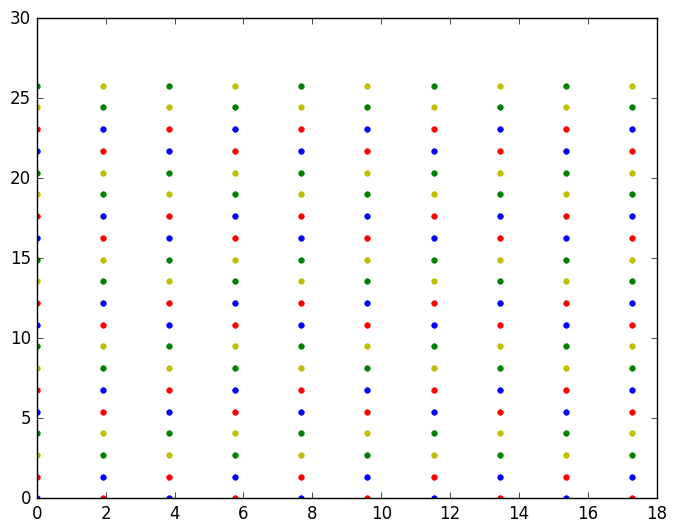

In [75]:
at = si_plane(5)
plot_layers(at)   #(X[1,:], X[2,:], "b.")

In [76]:
JuLIP.Visualise.show(at)

PyObject <IPython.core.display.HTML object>

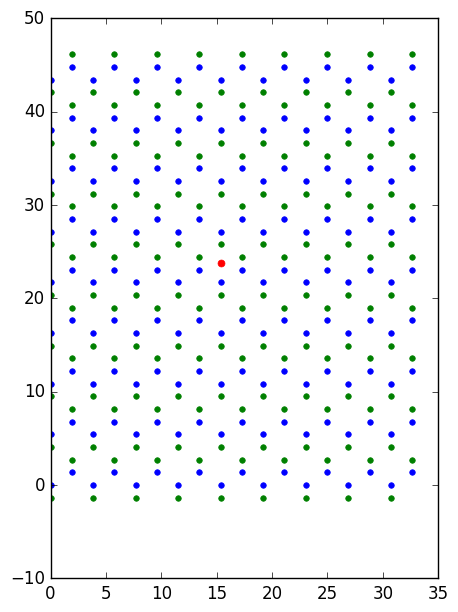

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329f83250>

In [4]:
at, b, x0 = si_plane(9)
figure(figsize=(5,7))
plot_layers(at, x0)
# axis("equal")

In [7]:
set_pbc!(at, true)
ctr = 0
for (i, j, r, R, _) in sites(at, rnn("Si") + 0.1)
    display(R)
    display( [dot(a, b) for a in R, b in R] )
    ctr += 1
    ctr == 3 && break
end 

4-element SubArray{StaticArrays.SVector{3,Float64},1,Array{StaticArrays.SVector{3,Float64},1},Tuple{UnitRange{Int64}},true}:
 [0.0,-1.3575,-1.91979]
 [0.0,-1.3575,1.91979] 
 [-1.91979,1.3575,0.0] 
 [1.91979,1.3575,0.0]  

4×4 Array{Float64,2}:
  5.52842  -1.84281  -1.84281  -1.84281
 -1.84281   5.52842  -1.84281  -1.84281
 -1.84281  -1.84281   5.52842  -1.84281
 -1.84281  -1.84281  -1.84281   5.52842

4-element SubArray{StaticArrays.SVector{3,Float64},1,Array{StaticArrays.SVector{3,Float64},1},Tuple{UnitRange{Int64}},true}:
 [0.0,-1.3575,-1.91979]
 [-1.91979,1.3575,0.0] 
 [1.91979,1.3575,0.0]  
 [0.0,-1.3575,1.91979] 

4×4 Array{Float64,2}:
  5.52842  -1.84281  -1.84281  -1.84281
 -1.84281   5.52842  -1.84281  -1.84281
 -1.84281  -1.84281   5.52842  -1.84281
 -1.84281  -1.84281  -1.84281   5.52842

4-element SubArray{StaticArrays.SVector{3,Float64},1,Array{StaticArrays.SVector{3,Float64},1},Tuple{UnitRange{Int64}},true}:
 [-1.91979,-1.3575,0.0]
 [1.91979,-1.3575,0.0] 
 [0.0,1.3575,-1.91979] 
 [0.0,1.3575,1.91979]  

4×4 Array{Float64,2}:
  5.52842  -1.84281  -1.84281  -1.84281
 -1.84281   5.52842  -1.84281  -1.84281
 -1.84281  -1.84281   5.52842  -1.84281
 -1.84281  -1.84281  -1.84281   5.52842

In [9]:
at2 = at * (1,1,2)
write("temp.xyz", at2)

In [13]:
at3 = bulk("Si", cubic = true) * (5,5,2)
write("temp2.xyz", at3)
# JuLIP.Visualise.show(at3)

In [77]:
# at, x0 = si_edge(9)
# plot_layers(at, x0)

In [78]:
# at, x0 = si_edge(31)
# calc = sw_eq()
# f = norm.(forces(calc, at))
# r = dists(at, x0)
# loglog(r, f, "r.", markersize=2)
# loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)

In [79]:
"""
a function that identifies multi-lattice structure in 2 layers of bulk-Si
(yes - very restrictive but will do for now!)
"""
function si_multilattice(at)
    I0 = Int[] 
    I1 = Int[]
    Idel = Int[]
    for (i, j, r, R, _) in sites(at, rnn("Si")+0.1)
        foundneig = false 
        for (jj, RR) in zip(j, R)
            if (RR[1] == 0.0) && (abs(RR[2] - 1.3575) < 1e-3)      
                # neighbour above >> make (i, jj) a site
                push!(I0, i)
                push!(I1, jj)
                foundneig = true
                break
            elseif (RR[1] == 0.0) && (abs(RR[2] + 1.3575) < 1e-3)  
                # neighbour below >> (jj, i) is a site that will be pushed when i ↔ jj
                foundneig = true
                break
            end
        end
        if !foundneig
            # i has no neighbour above or below >> probably we just get rid of it
            push!(Idel, i)
        end
    end
    return I0, I1, Idel 
end 


si_multilattice

In [109]:
at, _, _ = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
at |> positions

4-element Array{StaticArrays.SVector{3,Float64},1}:
 [0.0,0.0,0.0]          
 [1.91979,2.715,1.91979]
 [0.0,-1.3575,1.91979]  
 [1.91979,1.3575,0.0]   

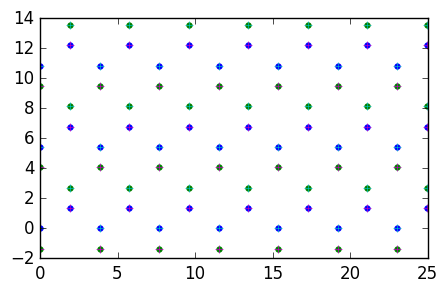

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32e7da2d0>

In [107]:
# testing si_multilattice

at, _, _ = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
at = at * (7, 3, 1)
I0, I1, Idel = si_multilattice(at)
X = positions(at) |> mat 

figure(figsize=(5,3))
plot_layers(at)
plot(X[1,I0], X[2,I0],"m+")
plot(X[1,I1], X[2,I1],"c+")
plot(X[1,Idel], X[3,Idel], "yx")


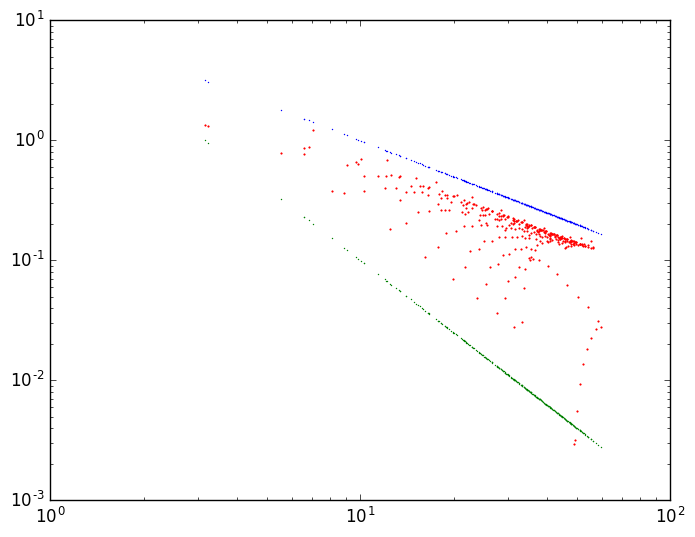

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x329ec9950>
 PyObject <matplotlib.lines.Line2D object at 0x32ae3c950>

In [98]:
at, _, _ = si_plane(9)
calc = sw_eq()
x0 = JVecF([-2.0, -2.0, 0.0])
u = x -> 0.4 * [(x-x0)[1:2]/norm((x-x0)[1:2]); 0.0]
X = [ x + u(x) for x in positions(at) ]
set_positions!(at, X)
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)


In [12]:
# at, _, _ = si_plane(15)
# set_pbc!(at, true)
# x0 = JVecF([-2.0, -2.0, 0.0])
# for (i, x) in enumerate(positions(at))
#     u = JVecF([x[1] - x0[1], x[2]-x0[2], 0.0]) / norm(x-x0) 
#     X[i] += u
# end 
# set_positions!(at, X)
# I0 = find(X[3,:] .== 0)
# @show length(I0)
# set_calculator!(at, calc)
# set_constraint!(at, FixedCell(at, clamp = I0))
# minimise!(at)
# f = norm.(forces(calc, at))
# r = dists(at, x0)
# loglog(r, f, "r.", markersize=2)
# loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)


LoadError: BoundsError: attempt to access 324-element Array{StaticArrays.SVector{3,Float64},1} at index [325]

In [11]:
function si_edge_outside(R) 
    at, b, xcore = si_plane(R)
    X = positions(at) |> mat
    X2d = X[1:2,:] .+ [2.0, 2.0]
    U = ulin_edge_isotropic(X2d, b, 0.25)
    X[1:2, :] += U
    set_positions!(at, vecs(X))
    return at, JVecF([2.0, 2.0, 0.0])
end 


si_edge_outside (generic function with 1 method)

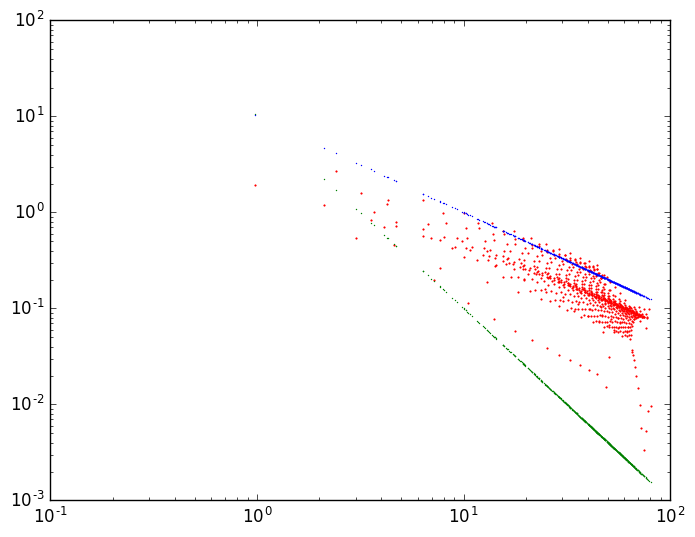

2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32f161110>
 PyObject <matplotlib.lines.Line2D object at 0x32f32be50>

In [12]:
at, x0 = si_edge_outside(13) 
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)

In [95]:
# using JuLIP, JuLIP.ASE, JuLIP.Potentials

# "a fully equilibrated SW potential"
# function sw_eq()
#     T(σ, at) = trace(stress(StillingerWeber(σ=σ), at))
#     at = JuLIP.ASE.bulk("Si", pbc=true)
#     r0 = 2.0951
#     r1 = r0 - 0.1 
#     s0, s1 = T(r0, at), T(r1, at)
#     while (abs(s1) > 1e-8) && abs(r0 - r1) > 1e-8
#         rnew = (r0 * s1 - r1 * s0) / (s1 - s0)
#         r0, r1 = r1, rnew
#         s0, s1 = s1, T(rnew, at)
#     end
#     return StillingerWeber(σ=r1)
# end 


function DpWcb(F, p, at = bulk("Si", pbc=true), sw = sw_eq())
    set_defm!(at, F)
    X = positions(at)
    X[2] = X[1] + p
    set_positions!(at, X)
    return -forces(sw, at)[2]
end


function DpDpWcb()
    at = bulk("Si", pbc=true)
    sw = sw_eq()
    F0 = defm(at)
    p0 = positions(at)[2] |> Vector
    h = 1e-5
    DpDpW = zeros(3, 3)
    for i = 1:3 
        p0[i] += h 
        DpW1 = DpWcb(F0, JVecF(p0), at, sw)
        p0[i] -= 2*h 
        DpW2 = DpWcb(F0, JVecF(p0), at, sw)
        p0[i] += h
        DpDpW[:, i] = (DpW1 - DpW2) / (2*h)
    end 
    return 0.5 * (DpDpW + DpDpW')
end


type WcbQuad
    DpDpW::Matrix{Float64}
    DpDpW_inv::Matrix{Float64}
    at::AbstractAtoms
    sw::StillingerWeber
end

function WcbQuad()
    DpDpW = DpDpWcb()
    return WcbQuad(DpDpW, pinv(DpDpW), bulk("Si", pbc=true), sw_eq())
end 

function (W::WcbQuad)(F)
    p0 = positions(W.at)[2]
    p1 = p0 - W.DpDpW_inv * DpWcb(F, p0, W.at, W.sw)
    p2 = p1 - W.DpDpW_inv * DpWcb(F, p1, W.at, W.sw)
    return p2
end

;

In [ ]:
# this is probably a test of WcbQuad, which I don't remember at all 

at = bulk("Si", cubic=false, pbc = true)
sw = sw_eq()
@show maxnorm(forces(sw, at))
F = defm(at)
G = rand(JMatF)
for p = 2:6
    h = 0.1^p 
    set_defm!(at, F + h * G, updatepositions=true)
    @show maxnorm(forces(sw, at))
end 
    ;

In [38]:
# this is probably another test of WcbQuad, which I don't remember at all 

at = bulk("Si", cubic=false, pbc = true)
sw = sw_eq()
@show maxnorm(forces(sw, at))
F0 = defm(at)
G = rand(JMatF)
W = WcbQuad()
for q = 2:6
    h = 0.1^q
    F = F0 + h * G
    ph = W(F)
    @show ph
    set_defm!(at, F, updatepositions=false)
    X = positions(at)
    X[2] = ph 
    set_positions!(at, X)
    @show maxnorm(forces(sw, at))
end 
;

r1 = 2.0947336035467163
maxnorm(forces(sw,at)) = 0.0
r1 = 2.0947336035467163
r1 = 2.0947336035467163
ph = [1.35913,1.35939,1.36145]
maxnorm(forces(sw,at)) = 0.00046276182227301656
ph = [1.35766,1.35769,1.3579]
maxnorm(forces(sw,at)) = 4.6557441051559756e-6
ph = [1.35752,1.35752,1.35754]
maxnorm(forces(sw,at)) = 4.6585626858496504e-8
ph = [1.3575,1.3575,1.3575]
maxnorm(forces(sw,at)) = 4.658898766266588e-10
ph = [1.3575,1.3575,1.3575]
maxnorm(forces(sw,at)) = 4.661300626297193e-12


In [114]:
# we now want to take the following example but apply 
# the minimised shifts

# at, _, _ = si_plane(9)
# calc = sw_eq()
# x0 = JVecF([-2.0, -2.0, 0.0])
# X = [ x + 0.4 * [((x-x0)/norm(x-x0))[1:2]; 0.0] for x in positions(at)]
# set_positions!(at, X)

function symml_displacement!(at, u)
    I0, I1, Idel = si_multilattice(at)
    @assert isempty(Idel)  # if Idel is not empty then (for now) we don't know what to do 
    X = positions(at)
    W = WcbQuad()
    F0 = defm(W.at)
    p0 = W(F0)
    for (i0, i1) in zip(I0, I1)   # each pair (i0, i1) corresponds to a ML lattice site
        x0, x1 = X[i0], X[i1]
        x̄ = 0.5 * (x0 + x1)   # centre of mass of the bond
        U, ∇U = u(x̄)          # displacement and displacement gradient
        p = W((I + ∇U) * F0)    # construct the shift corresponding to F = Id + ∇U
#         @show vecnorm(∇U), p-p0
        u0, u1 = U - 0.5 * (p-p0), U + 0.5 * (p-p0)
        X[i0], X[i1] = x0 + u0, x1 + u1
    end 
    set_positions!(at, X)
    return at 
end 

function ml_displacement!(at, u)
    I0, I1, Idel = si_multilattice(at)
    @assert isempty(Idel)  # if Idel is not empty then (for now) we don't know what to do 
    X = positions(at)
    W = WcbQuad()
    F0 = defm(W.at)
    @show p0 = W(F0)
    for (i0, i1) in zip(I0, I1)   # each pair (i0, i1) corresponds to a ML lattice site
        x0, x1 = X[i0], X[i1]
        #  THIS ISNT QUITE CORRECT - IT NEEDS A LOT OF TRANSFORMATIONS!!!!
        U, ∇U = u(x0)            # displacement and displacement gradient
        p = W((I + ∇U) * F0)     # construct the shift corresponding to F = Id + ∇U
        X[i0], X[i1] = x0 + U, x1 + U + p - p0
#         @show norm(p-p0) / vecnorm(∇U)
    end 
    set_positions!(at, X)
    return at 
end 



ml_displacement! (generic function with 1 method)

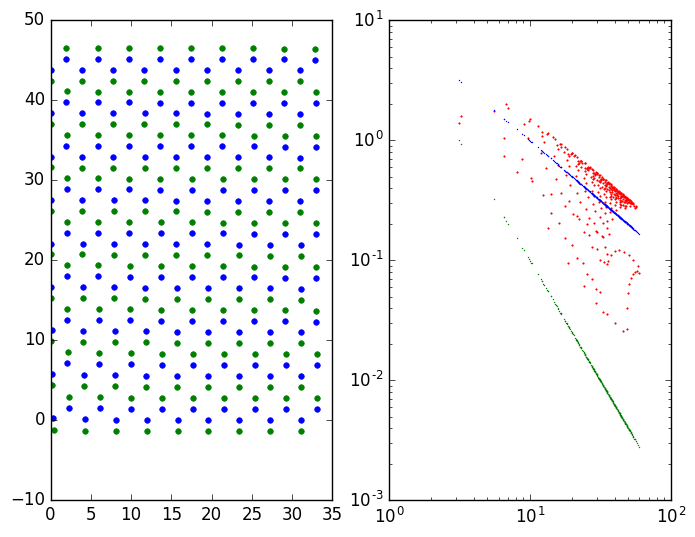

p0 = W(F0) = [1.3575,1.3575,1.3575]


2-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326adf0d0>
 PyObject <matplotlib.lines.Line2D object at 0x32e0735d0>

In [111]:
x0 = JVecF([-2.0, -2.0, 0.0])
u = x -> 0.4 * [(x-x0)[1:2]/norm((x-x0)[1:2]); 0.0]
∇u = x -> ForwardDiff.jacobian(u, x)

at, _, _ = si_plane(9)
ml_displacement!(at, x -> (u(x), ∇u(x)))

figure()
subplot(1,2,1)
plot_layers(at)

subplot(1,2,2)
f = norm.(forces(calc, at))
r = dists(at, x0)
loglog(r, f, "r.", markersize=2)
loglog(r, 10*r.^(-2), "g.", r, 10*r.^(-1), "b.", markersize=1)


In [112]:
at, _, _ = MaterialsScienceTools.Dislocations_Silicon_hard_110.fcc_edge_plane("Si")
at |> positions

4-element Array{StaticArrays.SVector{3,Float64},1}:
 [0.0,0.0,0.0]          
 [1.91979,2.715,1.91979]
 [0.0,-1.3575,1.91979]  
 [1.91979,1.3575,0.0]   

In [113]:
bulk("Si") |> positions

2-element Array{StaticArrays.SVector{3,Float64},1}:
 [0.0,0.0,0.0]         
 [1.3575,1.3575,1.3575]